In [82]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

This program uses locally downloaded data sets from the "Universum" github repo.

In [83]:
eeg_data = pd.read_csv('C:/Users/brend/GitHubRepos/Universum/DataCollection/data/EEGdata/103/1/3/eeg_data_raw.csv')

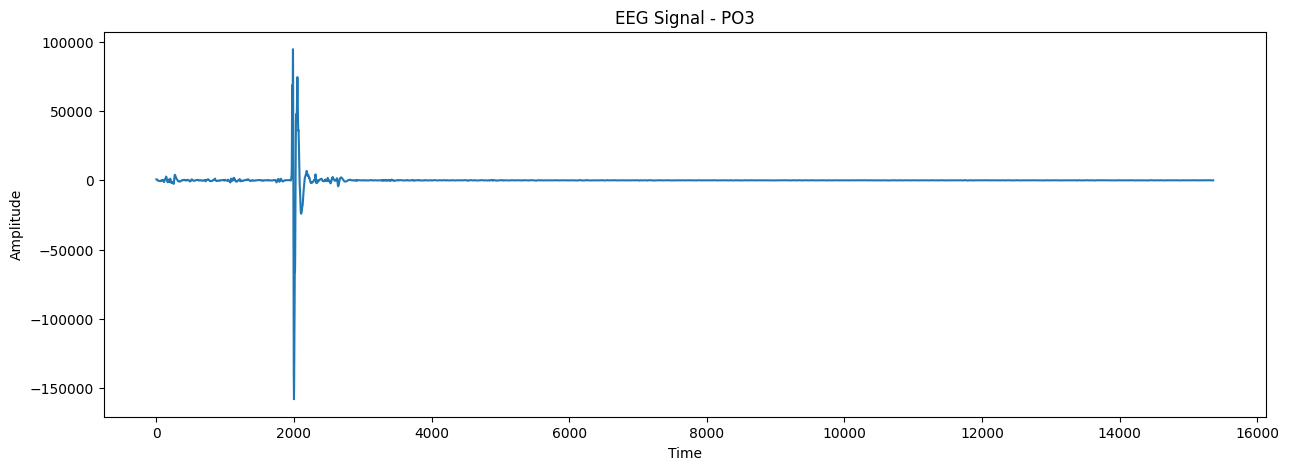

In [84]:
plt.figure(figsize=(15, 5))
plt.plot(eeg_data['PO3'])
plt.title('EEG Signal - PO3')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.show() # Plots only the EEG signal of the PO3 channel

I was successfully able to display the EEG signal of the PO3 channel.

In [85]:
import mne
from mne.viz import plot_topomap
from mne.channels import make_standard_montage

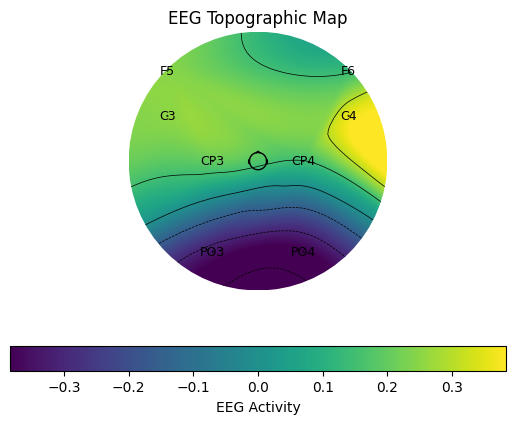

In [86]:
# Convert to NumPy and exclude timestamp
eeg_activity = eeg_data.iloc[:, 1:].values  # Exclude timestamp column

# Aggregate the data: Compute the mean across all time points
eeg_snapshot = eeg_activity.mean(axis=0)  # Shape: (8,)

# Define positions for the 8 EEG channels
positions = np.array([
    [-0.5, 0],   # CP3
    [-1, 0.5],   # C3
    [-1, 1],     # F5
    [-0.5, -1],  # PO3
    [0.5, -1],   # PO4
    [1, 1],      # F6
    [1, 0.5],    # C4
    [0.5, 0]     # CP4
])

# Define channel names
channel_names = ['CP3', 'C3', 'F5', 'PO3', 'PO4', 'F6', 'C4', 'CP4']

# Create the plot
fig, ax = plt.subplots()

# Plot the topomap for the 8 channels
im, _ = plot_topomap(eeg_snapshot, positions, axes=ax, show=False, cmap='viridis')

# Add channel names manually
for pos, name in zip(positions, channel_names):
    ax.text(pos[0], pos[1], name, fontsize=9, ha='center', va='center', color='black')

# Add a colorbar
plt.colorbar(im, ax=ax, orientation='horizontal', label="EEG Activity")
plt.title("EEG Topographic Map")
plt.show()

I was able to visualize some EEG data. The next steps are to quality check, handle artifacts, and format the data for training by Whitening the EEG Data Using PCA.

In [87]:
print(eeg_data.isnull().sum()) # All zeros confirms there are no missing data or anomalies

timestamp    0
CP3          0
C3           0
F5           0
PO3          0
PO4          0
F6           0
C4           0
CP4          0
dtype: int64


In [88]:
import pandas as pd
import numpy as np

eeg_data = pd.read_csv('C:/Users/brend/GitHubRepos/Universum/DataCollection/data/EEGdata/103/1/3/eeg_data_raw.csv')

# Convert to numpy array for easier processing
numpy_data = eeg_data.values

In [89]:
from scipy.signal import butter, filtfilt

start_noise_indice = 100
end_noise_indice = 120

def bandpass_filter(data, lowcut, highcut, fs, order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype="band")
    return filtfilt(b, a, data, axis=0)

fs = 256  # Sampling frequency
filtered_data = bandpass_filter(eeg_activity, lowcut=1, highcut=40, fs=fs)
signal_power = np.mean(filtered_data ** 2, axis=0)
noise_segment = eeg_activity[start_noise_indice:end_noise_indice]  # These are the start and:end for noise indices
noise_power = np.mean(noise_segment ** 2, axis=0)

Now to actually compute and display SNR using the formula:

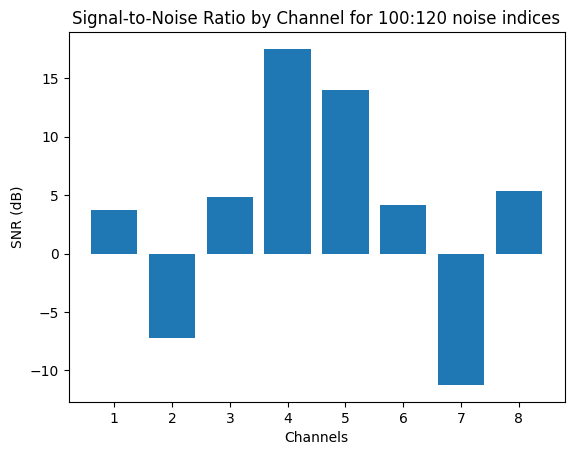

In [90]:
snr = 10 * np.log10(signal_power / noise_power)

channels = [f"{i+1}" for i in range(filtered_data.shape[1])]

plt.bar(channels, snr)
plt.xlabel("Channels")
plt.ylabel("SNR (dB)")
plt.title("Signal-to-Noise Ratio by Channel for " + str(start_noise_indice) +":" + str(end_noise_indice) + " noise indices")
plt.show()

Now that I can visualize SNL, I will try to remove line noise at 50/60 Hz using a notch filter:

In [91]:
from scipy.signal import iirnotch

def notch_filter(data, freq, fs, quality_factor=30):
    nyquist = 0.5 * fs
    freq = freq / nyquist
    b, a = iirnotch(freq, quality_factor)
    return filtfilt(b, a, data, axis=0)

filtered_data = notch_filter(filtered_data, freq=50, fs=fs)

I will set the threshold at 100 to detect eye blinks:

In [92]:
threshold = 100  # Microvolt threshold for artifacts
artifact_indices = np.where(np.abs(filtered_data) > threshold)

Next, I will try to detect abrupt, irregular changes in amplitude using a moving standard deviation::

In [93]:
window_size = int(fs * 0.5)  # 0.5-second window
motion_artifacts = np.std(filtered_data, axis=0) > np.mean(filtered_data) + 3 * np.std(filtered_data)

After detecting these artifacts, I will create a new data variable with the artifacts removed:

In [94]:
clean_eeg_activity = eeg_activity.copy()

# Iterate over each channel (column)
for channel in range(eeg_activity.shape[1]):
    # Extract the channel data
    channel_data = eeg_activity[:, channel]
    
    # Identify artifact indices for this channel
    artifact_indices = np.where(np.abs(channel_data) > threshold)[0]
    
    # Interpolate over artifact indices
    for index in artifact_indices:
        clean_eeg_activity[index, channel] = np.interp(
            index,
            np.delete(np.arange(len(channel_data)), artifact_indices),
            np.delete(channel_data, artifact_indices)
        )

In [95]:
filtered_data[:, motion_artifacts] = 0

print("Noisy channels zeroed out:", np.where(motion_artifacts)[0])

Noisy channels zeroed out: []


The array is empty, so there were no abrupt, irregular changes in amplitude detected from moving standard deviation.

In [107]:
# Define the bandpass filter
def bandpass_filter(data, lowcut, highcut, fs, order=4):
    nyquist = 0.5 * fs  # Nyquist frequency
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, data, axis=0)

# Apply bandpass filter to the EEG data
lowcut = 1  # Lower frequency cutoff (Hz)
highcut = 40  # Upper frequency cutoff (Hz)
filtered_data = bandpass_filter(eeg_activity, lowcut, highcut, fs)

print("Bandpass filtering complete.")

Bandpass filtering complete.


In [108]:
from scipy.signal import iirnotch

# Define the notch filter
def notch_filter(data, freq, fs, quality_factor=30):
    nyquist = 0.5 * fs
    freq = freq / nyquist  # Normalize frequency
    b, a = iirnotch(freq, quality_factor)
    return filtfilt(b, a, data, axis=0)

# Apply notch filter to remove line noise
notch_freq = 60  # Frequency to remove (60 Hz for US)
filtered_data = notch_filter(filtered_data, notch_freq, fs)

print("Notch filtering complete.")

Notch filtering complete.


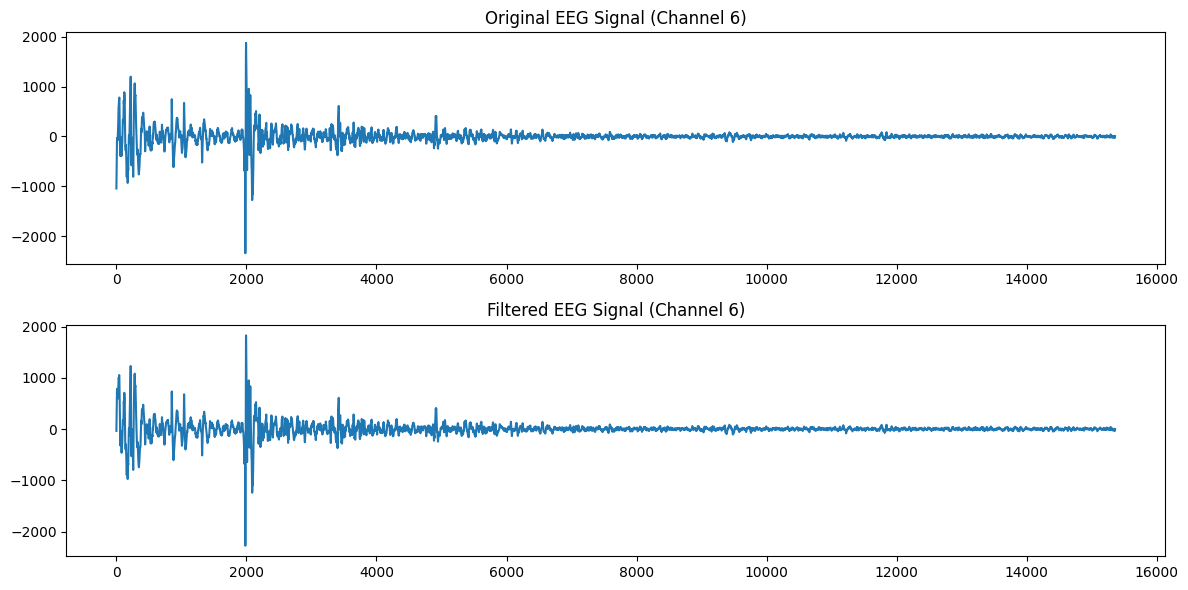

In [109]:
channel = 6  # Choose a channel to visualize

plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(eeg_activity[:, channel])
plt.title("Original EEG Signal (Channel {})".format(channel))

plt.subplot(2, 1, 2)
plt.plot(filtered_data[:, channel])
plt.title("Filtered EEG Signal (Channel {})".format(channel))
plt.tight_layout()
plt.show()

EEG data quality analysis findings:

Before and after filtering looks very similar, but if you look really closely after t = 2000 there are some small differences. 

All in all, there were some artifacts revealed and cleaned using a notch filter giving reason to believe eye blinks contributed to some of the noise. Other than that, there were little to no motion artifacts or major discrepicies detected in frequency.

All of the channels seem to detect a sudden spike telling me that something must have happened (perhaps the headset was moved) at time t = 2000.

Now onto PCA Whitening. PCA requires the data to be mean-centered and scaled to unit variance:

In [110]:
from sklearn.preprocessing import StandardScaler

# Standardize data (zero mean, unit variance)
scaler = StandardScaler()
standardized_data = scaler.fit_transform(eeg_activity)

print("Standardized data shape:", standardized_data.shape)

Standardized data shape: (15360, 8)


In [111]:
from sklearn.decomposition import PCA

# Apply PCA with whitening
pca = PCA(whiten=True)
whitened_data = pca.fit_transform(standardized_data)

print("Whitened data shape:", whitened_data.shape)

Whitened data shape: (15360, 8)


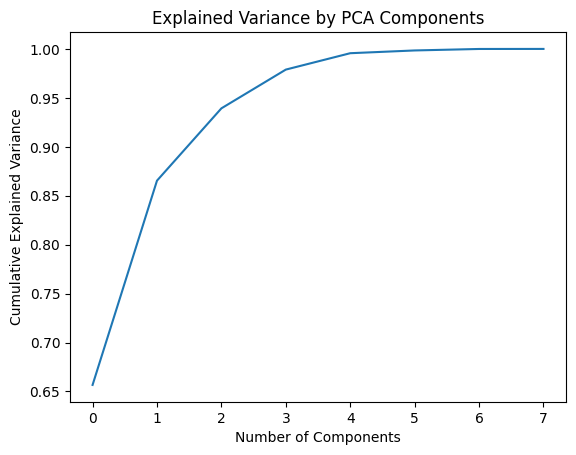

In [112]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by PCA Components')
plt.show()

In [113]:
# Saving whitened data for future use
np.save('eeg_data_whitened.npy', whitened_data)

Next, applying ICA:

In [116]:
from sklearn.decomposition import FastICA

ica = FastICA(n_components=8, random_state=0) # Used 8 as number of components for this specific data set
eeg_data_ica = ica.fit_transform(whitened_data)